# Reward design and testing

In [25]:
# Import relevant libraries

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')

import numpy as np
import os
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt

from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.rail_generators import SparseRailGen
from flatland.envs.observations import TreeObsForRailEnv

from src import test_utils, training, rewards
from src.observation_utils import normalize_observation
from src.models import *
from src.deep_model_policy import DeepPolicy, PolicyParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reward design

In [2]:
# Must modify two functions in env
#env.update_step_rewards
#env._handle_end_reward

Ideas :

- Dense reward from https://arxiv.org/pdf/2103.16511.pdf : -1 while not reaching, 0 if reached +1 if all trains reached
- Dense reward, ex : -1 while not reaching target or reward proportional to distance to target, but needs malus for collisions
- Sparse reward with bonus if all trains reach target
- Sparse reward with bonus if all trains reach target and malus for collisions
- Reward that evolves with training

JBR_0 : -5 deadlocked, +10 reached
JBR_1 : -1 deadlocked, +10 reached

Dense reward with bonus depart/arrival and malus for deadlocks : https://arxiv.org/pdf/2210.12933.pdf

Agents are given rewards at every time step, according to their performance within the moment. Besides the normalized reward generated by the environment, agents are also rewarded when they depart from stations, arrive at targets, and get penalized when deadlocks happen. To promote co-operation between them, these rewards are shared by all agents, and no credit assignment is performed. As a result, a single agent is encouraged to wait for others if the waiting can lead to global efficiency improvement.

In [2]:
test_envs = rewards.get_testing_environements(
    width=25,
    height=25,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=False,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=5, 
    obs_builder_object=TreeObsForRailEnv(max_depth=2),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=5,  # Minimal duration
            max_duration=20,  # Max duration
        )
    )
)

## Testing

In [3]:
# Train this environment
# RELANCER DENSE
key = "DoubleEnd"

env = test_envs[key]

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=128, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 30

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size, hidsize1=128, hidsize2=128)
policy = DeepPolicy(model, policy_params)

Using CPU


In [4]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.99,
    "n_episodes": 1500,
    "checkpoint_interval": 100,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

In [5]:
if key not in os.listdir('pauline/') :
    os.mkdir('pauline/' + key)

In [6]:
training.train_agent(env, policy, train_params, obs_params, checkpoints_folder='pauline/'+key+'/')


💾 Replay buffer status: 0/100000 experiences

🚉 Training 5 trains on 25x25 grid for 1500 episodes, evaluating on 1 episodes every 100 episodes.



🚂 Episode 0	 🏆 Score: -0.409 Avg: -0.994	 💯 Done: 40.00% Avg: 0.40%	 🎲 Epsilon: 0.990 	 🔀 Action Probs: ↻ 0.215 ← 0.201 ↑ 0.183 → 0.219 ◼ 0.183  	✅ Eval: score -0.860 done 0.0%
	🔍 Evaluation score: -0.860 done: 0.0%
🚂 Episode 100	 🏆 Score: -0.691 Avg: -0.800	 💯 Done: 0.00% Avg: 8.22%	 🎲 Epsilon: 0.362 	 🔀 Action Probs: ↻ 0.072 ← 0.043 ↑ 0.279 → 0.236 ◼ 0.370  	✅ Eval: score -0.800 done 0.0%
	🔍 Evaluation score: -0.800 done: 0.0%
🚂 Episode 200	 🏆 Score: -0.627 Avg: -0.585	 💯 Done: 0.00% Avg: 13.44%	 🎲 Epsilon: 0.133 	 🔀 Action Probs: ↻ 0.155 ← 0.075 ↑ 0.144 → 0.064 ◼ 0.561   	✅ Eval: score -1.167 done 0.0%
	🔍 Evaluation score: -1.167 done: 0.0%
🚂 Episode 244	 🏆 Score: -0.384 Avg: -0.529	 💯 Done: 20.00% Avg: 16.06%	 🎲 Epsilon: 0.085 	 🔀 Action Probs: ↻ 0.290 ← 0.194 ↑ 0.235 → 0.051 ◼ 0.230  

/Data/pamrouche/anaconda3/envs/flatland-marl/lib/python3.9/site-packages/flatland/envs/rail_generators.py:351: UserWarning: Could not set all required cities! Created 1/2
  warnings.warn(city_warning)
/Data/pamrouche/anaconda3/envs/flatland-marl/lib/python3.9/site-packages/flatland/envs/rail_generators.py:263: UserWarning: [WARNING] Changing to Grid mode to place at least 2 cities.
  warnings.warn("[WARNING] Changing to Grid mode to place at least 2 cities.")


🚂 Episode 300	 🏆 Score: -0.479 Avg: -0.470	 💯 Done: 0.00% Avg: 21.25%	 🎲 Epsilon: 0.049 	 🔀 Action Probs: ↻ 0.140 ← 0.038 ↑ 0.220 → 0.110 ◼ 0.492   	✅ Eval: score -0.256 done 60.0%
	🔍 Evaluation score: -0.256 done: 60.0%
🚂 Episode 400	 🏆 Score: -0.516 Avg: -0.383	 💯 Done: 20.00% Avg: 30.44%	 🎲 Epsilon: 0.018 	 🔀 Action Probs: ↻ 0.030 ← 0.142 ↑ 0.345 → 0.401 ◼ 0.081   	✅ Eval: score -0.179 done 40.0%
	🔍 Evaluation score: -0.179 done: 40.0%
🚂 Episode 500	 🏆 Score: -0.781 Avg: -0.259	 💯 Done: 20.00% Avg: 49.23%	 🎲 Epsilon: 0.010 	 🔀 Action Probs: ↻ 0.101 ← 0.186 ↑ 0.025 → 0.492 ◼ 0.196   	✅ Eval: score 0.053 done 100.0%
	🔍 Evaluation score: 0.053 done: 100.0%
🚂 Episode 600	 🏆 Score: -0.105 Avg: -0.215	 💯 Done: 80.00% Avg: 55.67%	 🎲 Epsilon: 0.010 	 🔀 Action Probs: ↻ 0.019 ← 0.148 ↑ 0.512 → 0.302 ◼ 0.019   	✅ Eval: score -0.016 done 60.0%
	🔍 Evaluation score: -0.016 done: 60.0%
🚂 Episode 700	 🏆 Score: 0.133 Avg: -0.162	 💯 Done: 100.00% Avg: 64.74%	 🎲 Epsilon: 0.010 	 🔀 Action Probs: ↻ 0.10

In [7]:
policy.load(f'pauline/{key}/checkpoint_1499.pth')

In [8]:
env = test_envs['baseline']

In [9]:
# Test the policy
n_test = 100

scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

	✅ Eval: score -0.138 done 68.0%


In [126]:
# Test the policy
n_test = 100

scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

	✅ Eval: score -0.110 done 74.2%


In [11]:
# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

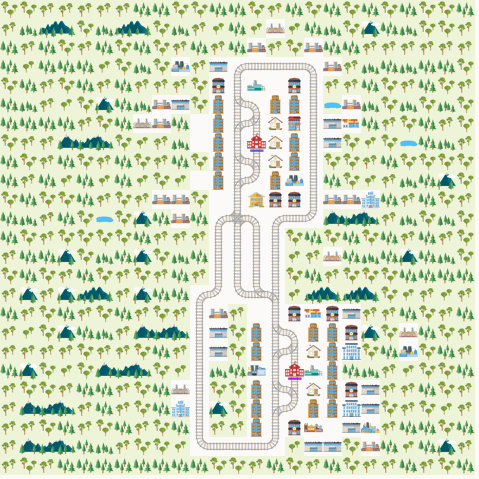

In [12]:
# Test the policy on the worst seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

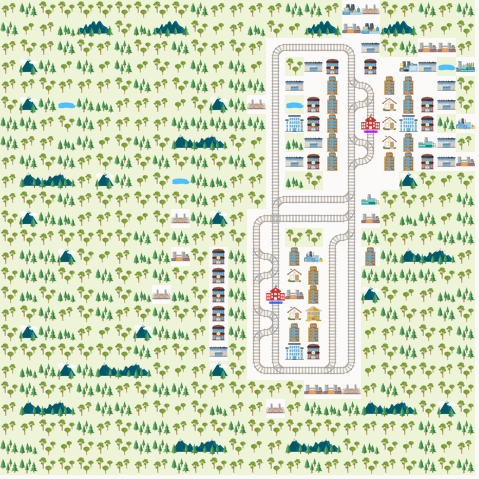

In [13]:
# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

# Run all tests

In [7]:
# Create results.csv
if 'results.csv' not in os.listdir('pauline/'):
    results = pd.DataFrame(columns=['env', 'epoch', 'scores', 'completions', 'nb_steps', 'seeds'])
    results.to_csv('pauline/results.csv', index=False)

results = pd.read_csv('pauline/results.csv')

In [34]:
# Test the policy on all environments every 200 epochs
env = test_envs['baseline']
seeds_test = range(2000, 2100)

for test_env in ['baseline', 'Collective', 'Dense_1_pas_fou', 'Dense_2_pas_fou_non_plus', 'JBREnd', 'DoubleEnd', 'JBR_0', 'JBR_1', 'JBR_2', 'JBR_Norm']:
    for epoch in list(range(0, 1499, 100)) + [1499]:
        # If the test has already been done, skip
        print(f"Testing {test_env} at epoch {epoch}")
        if len(results[(results['env'] == test_env) & (results['epoch'] == epoch)]) > 0:
            print('Already tested')
            continue
        policy.load(f'pauline/{test_env}/checkpoint_{epoch}.pth')
        n_test = 100
        scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params, seeds=seeds_test)
        row_to_add = {'env': test_env, 'epoch': epoch, 'scores': scores, 'completions': completions, 'nb_steps': nb_steps, 'seeds': seeds}
        results = results.append(row_to_add, ignore_index=True)
        results.to_csv('pauline/results.csv', index=False)
print('DONE')

Testing baseline at epoch 0
Already tested
Testing baseline at epoch 100


# Analyze results

In [22]:
results['env'].unique()

array(['baseline', 'Collective', 'Dense_1_pas_fou',
       'Dense_2_pas_fou_non_plus', 'JBREnd', 'DoubleEnd', 'JBR_0',
       'JBR_1', 'JBR_2', 'JBR_Norm'], dtype=object)

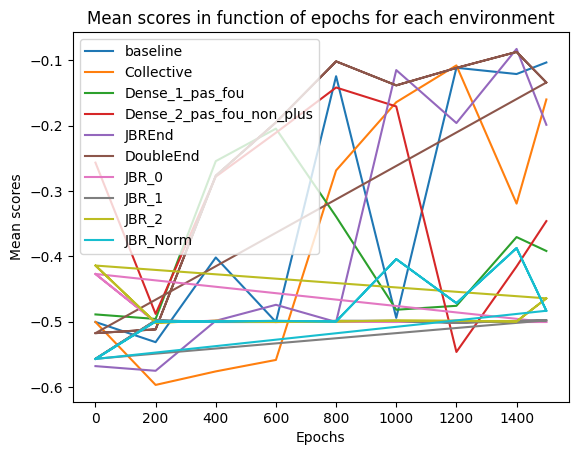

In [26]:
results = pd.read_csv('pauline/results.csv')

for col in ['scores', 'completions', 'nb_steps', 'seeds']:
    results[col] = results[col].apply(literal_eval)

# Get the mean of scores and completions
results['mean_scores'] = results['scores'].apply(np.mean)
results['mean_completions'] = results['completions'].apply(np.mean)

# Draw mean scores in function of epochs for each environment
for env in results['env'].unique():
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_scores'], label=env)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean scores')
plt.title('Mean scores in function of epochs for each environment')
plt.show()

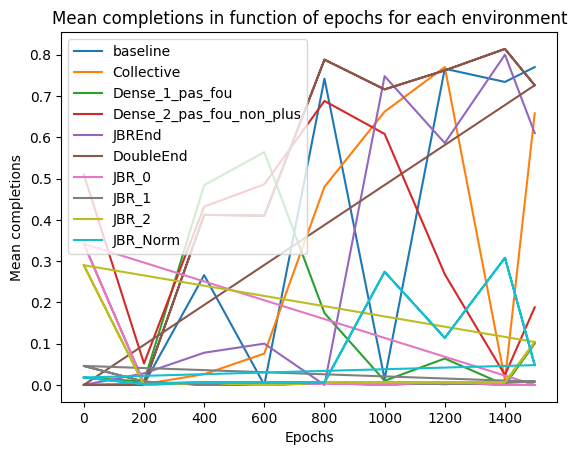

In [27]:
# Draw mean completions in function of epochs for each environment
for env in results['env'].unique():
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_completions'], label=env)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean completions')
plt.title('Mean completions in function of epochs for each environment')
plt.show()

In [29]:
# Remove duplicates
results = results.drop_duplicates(subset=['env', 'epoch'])

In [31]:
results.to_csv('pauline/results.csv', index=False)

In [32]:
# Order by best mean completions
results.sort_values('mean_completions', ascending=False)

env  epoch                                             scores  \
52        DoubleEnd   1400  [-0.24, 0.0, -0.22325581395348837, -0.26666666...   
43           JBREnd   1400  [-0.28444444444444444, 0.0, -0.153488372093023...   
49        DoubleEnd    800  [0.0, 0.0, -0.2837209302325581, -0.32, -0.1260...   
8          baseline   1499  [0.0, 0.0, -0.26976744186046514, -0.304, 0.0, ...   
15       Collective   1200  [-0.24, 0.0, -0.2186046511627907, -0.253333333...   
..              ...    ...                                                ...   
36           JBREnd      0  [-0.5644444444444444, -0.6285714285714286, -0....   
25  Dense_1_pas_fou   1400  [-0.4, -0.37551020408163266, -0.39069767441860...   
9        Collective      0  [-0.49333333333333335, -0.5265306122448979, -0...   
3          baseline    600  [-0.49333333333333335, -0.5265306122448979, -0...   
45        DoubleEnd      0  [-0.5066666666666667, -0.5346938775510204, -0....   

                                          completions  \
52  [0.4, 1.0, 0.6, 0.4, 0.6, 1.0, 0.4, 0.4, 0.2, ...   
43  [0.4, 1.0, 0.6, 0.4, 1.0, 1.0, 1.0, 0.4, 1.0, ...   
49  [1.0, 1.0, 0.4, 0.4, 0.8, 0.4, 1.0, 1.0, 0.8, ...   
8   [1.0, 1.0, 0.4, 0.2, 1.0, 1.0, 1.0, 0.6, 0.0, ...   
15  [0.4, 1.0, 0.6, 0.4, 1.0, 1.0, 1.0, 0.4, 0.0, ...   
..                                                ...   
36  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
25  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
45  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             nb_steps  \
52  [44, 32, 42, 74, 45, 35, 45, 47, 40, 34, 29, 3...   
43  [44, 32, 42, 74, 29, 33, 32, 47, 28, 35, 29, 3...   
49  [31, 32, 42, 74, 45, 52, 45, 41, 40, 33, 42, 4...   
8   [30, 31, 42, 74, 29, 33, 32, 47, 40, 36, 42, 3...   
15  [44, 32, 42, 74, 29, 33, 45, 47, 40, 36, 29, 3...   
..                                                ...   
36  [44, 48, 42, 74, 45, 52, 45, 47, 40, 51, 42, 4...   
25  [44, 48, 42, 74, 45, 52, 45, 47, 40, 51, 42, 4...   
9   [44, 48, 42, 74, 45, 52, 45, 47, 40, 51, 42, 4...   
3   [44, 48, 42, 74, 45, 52, 45, 47, 40, 51, 42, 4...   
45  [44, 48, 42, 74, 45, 52, 45, 47, 40, 51, 42, 4...   

                                                seeds  mean_scores  \
52  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.087007   
43  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.082395   
49  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.101489   
8   [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.103138   
15  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.107636   
..                                                ...          ...   
36  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.568230   
25  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.370582   
9   [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.500640   
3   [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.500640   
45  [2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...    -0.517718   

    mean_completions  
52             0.814  
43             0.800  
49             0.788  
8              0.770  
15             0.770  
..               ...  
36             0.000  
25             0.000  
9              0.000  
3              0.000  
45             0.000  

[90 rows x 8 columns]

# Example Render - toy test

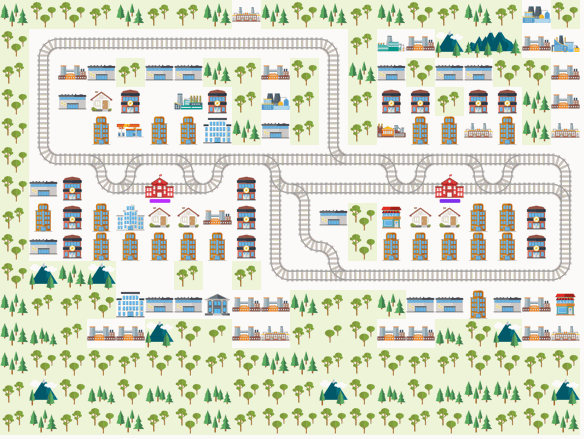

In [3]:
# Step loop with video rendering, shortest path policy

obs, info = env.reset(random_seed=10)
env_renderer = test_utils.RenderWrapper(env, real_time_render=False, force_gif=True)
env_renderer.render()

while True:
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = 2
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render()
    if done['__all__']:
        break

env_renderer.make_gif('test.gif')